# 계층적 에이전트 팀


---

**왜 계층적 에이전트 팀인가?**

이전 Supervisor 예제에서는 하나의 supervisor node가 여러 작업자 노드에게 작업을 할당하고 결과를 취합

- **작업 복잡성 증가**: 단일 supervisor로는 한 번에 처리할 수 없는 다양한 하위 영역의 전문 지식이 필요할 수 있습니다.
- **작업자 수 증가**: 많은 수의 작업자를 관리할 때, 단일 supervisor가 모든 작업자에게 직접 명령을 내리면 관리 부담이 커집니다.


---



1. **도구 생성**: 웹 연구(Web Research) 및 문서 작성(Documentation)을 위한 에이전트 도구 정의    
2. **에이전트 팀 정의**: 연구 팀 및 문서 작성 팀을 계층적으로 정의하고 구성  
3. **계층 추가**: 상위 수준 그래프와 중간 수준 감독자를 통해 전체 작업을 계층적으로 조정  
4. **결합**: 모든 요소를 통합하여 최종적인 계층적 에이전트 팀 구축

---


## 환경 설정

In [8]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.6 MB/s eta 0:00:00


In [9]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews

import os

In [ ]:
# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "LangGraph_Hi_Agent_Team"


from langchain_teddynote.tools.tavily import TavilySearch
import os


In [11]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


## 도구 생성

각 팀은 하나 이상의 에이전트로 구성되며, 각 에이전트는 하나 이상의 도구를 사용

먼저 연구 팀을 살펴보겠습니다.

**ResearchTeam 도구**

ResearchTeam은 웹에서 정보를 찾기 위해 검색 엔진과 URL 스크래퍼를 사용

In [12]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.tools import tool

# 검색 도구 정의(TavilySearch)
tavily_tool = TavilySearch(max_results=5)


# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

**문서 작성 팀 도구**

에이전트가 파일 시스템에 접근할 수 있도록 하며, 이는 안전하지 않을 수 있습니다. 따라서, 사용에 주의가 필요합니다.

In [13]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")

# tmp 폴더가 없으면 생성
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

코드 실행 도구인 `PythonREPLTool` 을 정의합니다.

In [14]:
from langchain_experimental.tools import PythonREPLTool

# PythonREPL 도구
python_repl_tool = PythonREPLTool()

## 다중 에이전트 생성을 위한 유틸리티 함수 정의



1. `worker agent` 생성.
2. `sub-graph`의 `supervisor` 생성.

In [15]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory(MODEL_NAME)

아래는 `AgentFactory` 를 사용하여 에이전트 노드를 생성하는 예시입니다.

예시에서는 검색 에이전트를 생성하는 방법을 살펴보겠습니다.

In [16]:
# 에이전트 정의
search_agent = create_react_agent(llm, tools=[tavily_tool])
# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

팀 감독자(Team Supervisor)를 생성하는 함수입니다.

In [17]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))

    # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

## 에이전트 팀 정의



### 연구 팀(Research Team)

연구 팀은 `search agent`와 `web scraping`을 담당하는 `research_agent`라는 두 개의 작업자 노드를 구성

In [18]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 상태 정의
class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]  # 메시지
    team_members: List[str]  # 멤버 에이전트 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# 검색 노드 생성
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

# 웹 스크래핑 노드 생성
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

In [19]:
def get_next_node(x):
    return x["next"]

### Research Team 그래프 생성

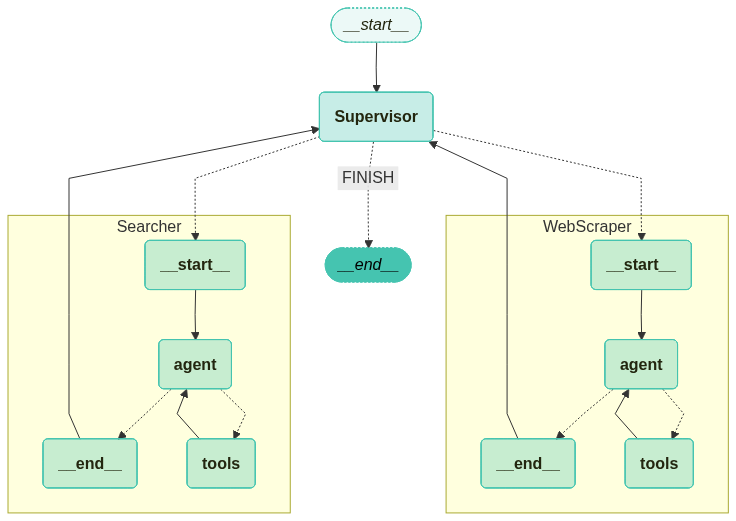

In [20]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

`web_research_app` 을 실행합니다.

In [21]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 50):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [22]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_xZlLZUiYR7r7kLwAtzOrLRam)
 Call ID: call_xZlLZUiYR7r7kLwAtzOrLRam
  Args:
    urls: ['https://finance.naver.com/news']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="네이버페이 증권">



네이버페이 증권



































메인 메뉴로 바로가기
본문으로 바로가기










네이버





페이






증권






증권 종목명·지수명 검색







검색


자동완성







@code@
@txt@
@market@

@full_txt@
@in_code@
@in_name@
@in_link@
@in_market@




												공모주와 해외 종목은 모바일 페이지로 이동합니다.
											








												현재 자동완성 기능을 사용하고 계십니다.
											









												자동완성 기능이 활성화되었습니다.
				

In [23]:
# 최종 결과 출력
print(output["messages"][-1].content)

Here are the major news highlights from the Naver Finance news page:

1. **New York Stock Exchange Rises Despite Employment Slowdown Signals**  
   - Source: [Asia Economy](https://finance.naver.com/news)

2. **Separate People for Acrobatics and Earning Money? Why Apple Smiles at Google's Victory**  
   - Source: [Maeil Business Newspaper](https://finance.naver.com/news)

3. **New York Stock Exchange Maintains Optimism Despite Employment Slowdown**  
   - Source: [Yonhap News](https://finance.naver.com/news)

4. **"Is There Any Other Way to Profit in the Box Market?" Short-term Investors Flock to Cosmetic Stocks**  
   - Source: [Maeil Business Newspaper](https://finance.naver.com/news)

5. **[Exclusive] Bigger Problem than Dual Listing... LS Essix Solutions Faces Listing Difficulties Due to Multi-layered Governance Structure**  
   - Source: [Edaily](https://finance.naver.com/news)

6. **"Persistent Rotation Market"... There is an Exit**  
   - Source: [Korea Economic TV](https://fina

### 문서 작성 팀(Doc Writing Team)

이번에는 문서 작성 팀을 생성.

각 agent에게 서로 다른 file-writing 도구에 대한 접근 권한을 부여

In [26]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # tmp 폴더가 없으면 생성


# 상태 정의
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # 현재 작업중인 파일


# 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함
def preprocess(state):
    # 작성된 파일 목록 초기화
    written_files = []

    try:
        # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    # 작성된 파일이 없으면 상태에 "No files written." 추가
    if not written_files:
        return {**state, "current_files": "No files written."}

    # 작성된 파일 목록을 상태에 추가
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME)

# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# 노트 작성 노드
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)


# 차트 생성 에이전트 생성
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

### Doc Writing Team 그래프 생성

In [27]:
# 그래프 생성
authoring_graph = StateGraph(DocWritingState)

# 노드 정의
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# 엣지 정의
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# 시작 노드 설정
authoring_graph.set_entry_point("Supervisor")

# 그래프 컴파일
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

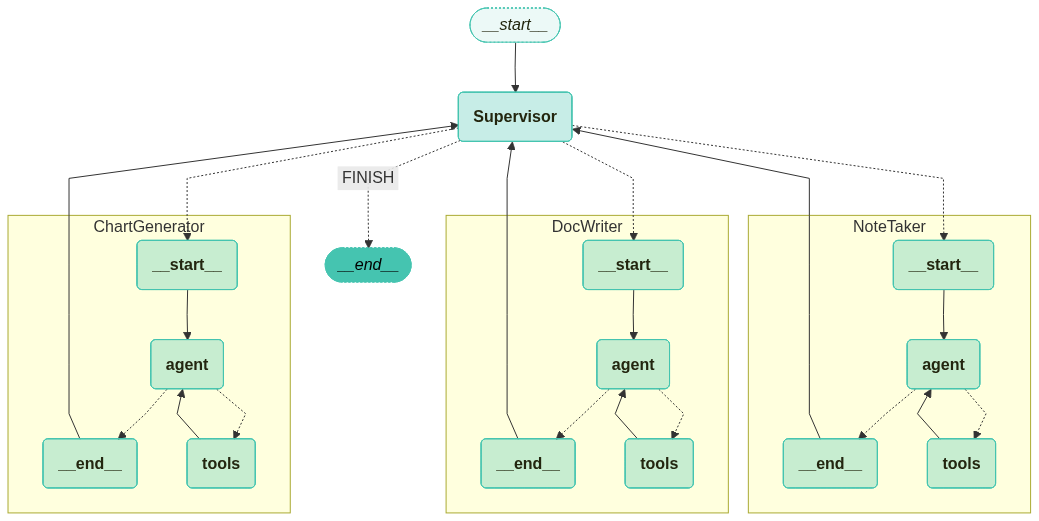

In [28]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(authoring_app, xray=True)

그래프를 실행하고 결과를 확인합니다.

In [29]:
output = run_graph(
    authoring_app,
    "Transformer 의 구조에 대해서 심층 파악해서 논문의 목차를 한글로 작성해줘. "
    "그 다음 각각의 목차에 대해서 5문장 이상 작성해줘. "
    "상세내용 작성시 만약 chart 가 필요하면 차트를 작성해줘. "
    "최종 결과를 저장해줘. ",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
DocWriter

🔄 Node: agent in [DocWriter] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_document (call_ot6JnjUJNQezRqPc7G2xM14i)
 Call ID: call_ot6JnjUJNQezRqPc7G2xM14i
  Args:
    content: # Transformer 구조에 대한 논문 목차 및 상세 설명

## 1. 서론
Transformer는 자연어 처리 분야에서 혁신적 성과를 이뤄낸 모델로 자리잡았다. 기존의 RNN이나 LSTM 모델과는 달리, Transformer는 Attention 메커니즘에 기반하여 병렬 처리를 극대화하면서도 높은 정확도를 보여준다. 이 논문의 목적은 Transformer의 구조와 작동 원리를 심층적으로 파악하는 데 있다. 본 논문에서는 Encoder와 Decoder 구조, Self-Attention 및 Multi-Head Attention, Positional Encoding 등의 핵심 요소들을 자세히 설명한다.

## 2. Transformer의 기본 구조
Transformer는 Encoder와 Decoder 두 부분으로 구성되어 있다. Encoder는 입력 데이터를 받아들이고, 이를 통해 문맥에 맞는 특성 벡터를 생성한다. Decoder는 Encoder에서 생성한 벡터를 바탕으로 출력 데이터를 생성한다. 각각의 Encoder와 Decoder는 여러 개의 Layer로 구성되어 있으며, 각 Layer는 Self-Attention 및 Feed-Forward Network를 포함한다. 이러한 구조 덕분에 Transfo


🔄 Node: agent in [ChartGenerator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_qzYfVwSnxulkw0WL9IeOjasL)
 Call ID: call_qzYfVwSnxulkw0WL9IeOjasL
  Args:
    query: content = """
1. 서론

Transformer는 2017년에 구글이 발표한 혁신적인 자연어 처리 모델로, 기존 순환 신경망 기반의 모델들에 비해 높은 정확도와 빠른 학습 속도를 제공합니다. 이 모델은 번역, 요약, 질의응답 등의 자연어 처리 작업에서 큰 성능 향상을 보여주며, 많은 후속 모델들에 영향을 미쳤습니다. 병렬로 시퀀스를 처리할 수 있어 빠르며 대량의 데이터를 효율적으로 처리할 수 있습니다. 애텐션 메커니즘을 통해 입력 시퀀스의 요소 간 관련성을 학습하여 문맥 이해 능력을 향상시킵니다. 이 논문에서는 Transformer의 주요 구성 요소와 각각의 역할을 심층 분석하여 모델의 작동 원리를 설명합니다.

2. Transformer의 기본 구조

인코더와 디코더라는 두 주요 구성 요소로 이루어져 있으며, 각각 여러 층으로 구성됩니다. 인코더는 입력 시퀀스를 받아 문맥을 이해하는 용도로 사용하며, Self-Attention 메커니즘을 활용합니다. 디코더는 인코더로부터 받은 문맥 정보를 바탕으로 새로운 시퀀스를 생성하고, 이 과정에서 Self-Attention과 인코더-디코더 애텐션을 활용합니다. 포지션 와이즈 피드 포워드 네트워크와 Residual connection, layer normalization은 각 층의 안정적인 학습을 지원합니다. 이러한 구조는 전체 모델의 수렴 속도를 높이고 성능을 향상시킵니다.

3. Self-Attention

## Super-Graph 생성

이 설계에서는 **상향식 계획 정책**을 적용하고 있습니다. 이미 두 개의 그래프를 생성했지만, 이들 간의 작업을 어떻게 라우팅할지 결정해야 합니다.

이를 위해 **Super Graph**를 정의하여 이전 두 그래프를 조정하고, 이 상위 수준 상태가 서로 다른 그래프 간에 어떻게 공유되는지를 정의하는 연결 요소를 추가할 것입니다.

먼저, 총 감독자 노드를 생성합니다.

In [30]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# 기본 LLM으로 ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model=MODEL_NAME)

# 팀 감독자 노드 생성
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

다음은 Super-Graph의 상태와 노드를 정의 합니다.

Super-Graph 는 단순하게 Task 를 라우팅 하는 역할이 주를 이룹니다.

In [31]:
from typing import TypedDict, List, Annotated
import operator


# 상태 정의
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # 라우팅 결정
    next: str


# 마지막 메시지 반환 노드
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# 응답 종합 노드
def join_graph(response: dict):
    # 마지막 메시지를 추출하여 메시지 목록으로 반환
    return {"messages": [response["messages"][-1]]}

### Super-Graph 정의

이제 2개의 팀을 연결하는 Super-Graph를 정의합니다.

In [32]:
# 그래프 정의
super_graph = StateGraph(State)

# 노드 정의
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# 엣지 정의
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# 조건부 엣지 추가: Supervisor 의 결정에 따라 다음 노드로 이동
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Supervisor 노드를 시작 노드로 설정
super_graph.set_entry_point("Supervisor")

# 그래프 컴파일
super_graph = super_graph.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

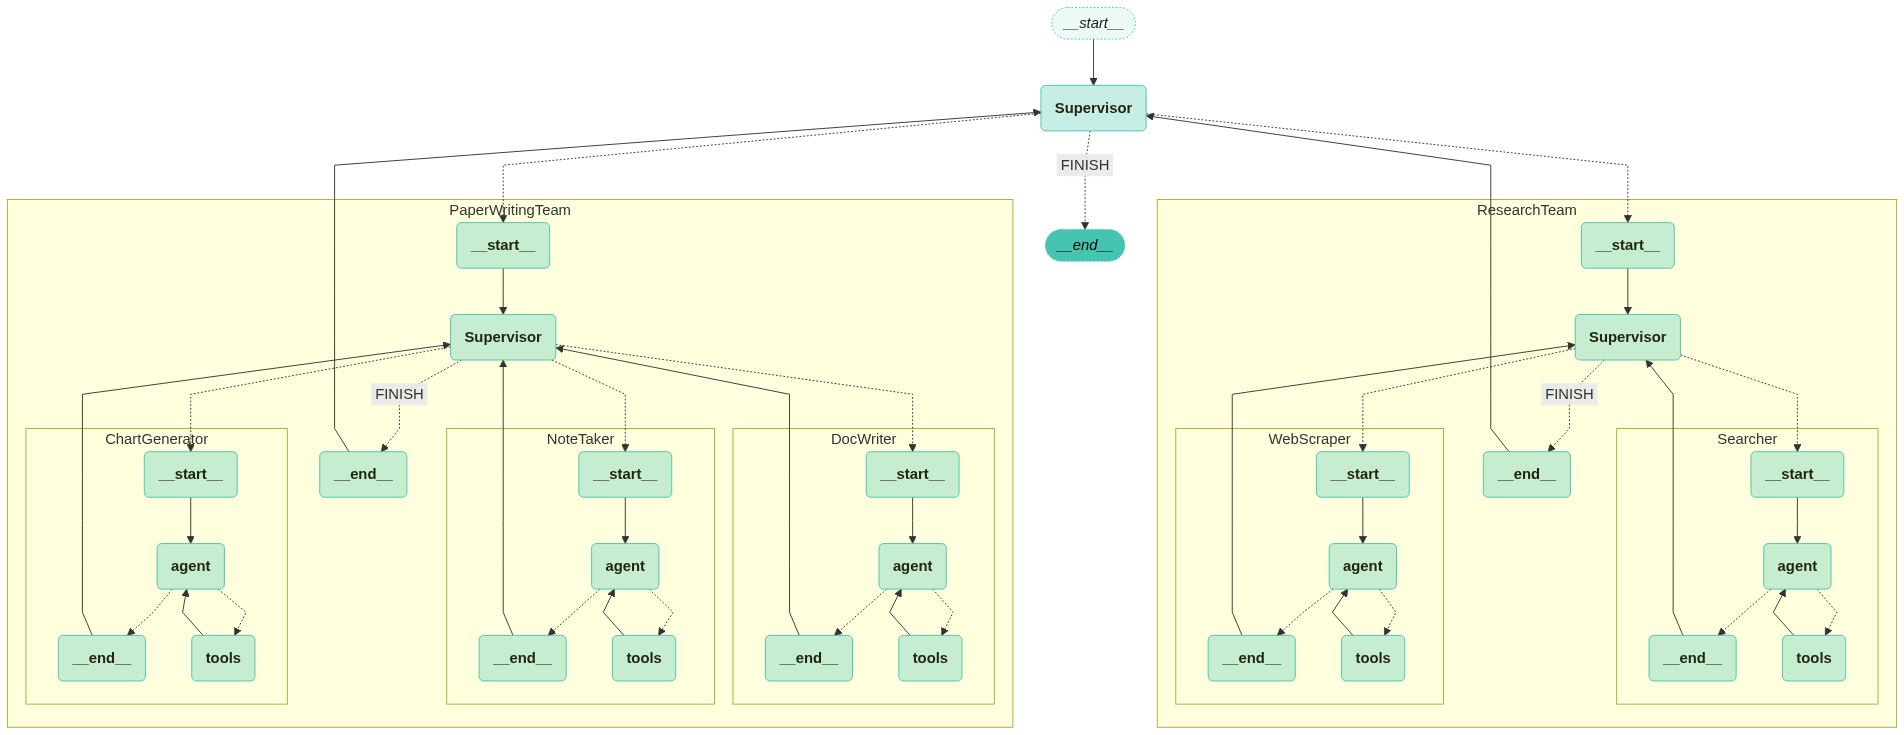

In [33]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(super_graph, xray=True)

In [34]:
output = run_graph(
    super_graph,
    """주제: multi-agent 구조를 사용하여 복잡한 작업을 수행하는 방법

상세 가이드라인:
- 주제에 대한 Arxiv 논문 형식의 리포트 생성
- Outline 생성
- 각각의 Outline 에 대해서 5문장 이상 작성
- 상세내용 작성시 만약 chart 가 필요하면 차트 생성 및 추가
- 한글로 리포트 작성
- 출처는 APA 형식으로 작성
- 최종 결과는 .md 파일로 저장""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

## Arxiv 논문 형식의 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

### Outline

1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 시 고려사항
6. 결론

---

### 1. 서론

Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 시 고려해야 할 요소들을 제시합니다.

### 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 구조로, 각 에이전트는 독립적인 의사결정 능력을 갖추고 있

마크다운 형식으로 최종 결과물을 출력합니다.

In [35]:
from IPython.display import Markdown

if hasattr(output["messages"][-1], "content"):
    display(Markdown(output["messages"][-1].content))
else:
    display(Markdown(output["messages"][-1]))

```markdown
# Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## 1. 서론

Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 시 고려해야 할 요소들을 제시합니다.

## 2. Multi-Agent 시스템의 개요

Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 구조로, 각 에이전트는 독립적인 의사결정 능력을 갖추고 있습니다. 이러한 시스템은 분산된 환경에서의 문제 해결에 적합하며, 각 에이전트는 특정 역할을 수행하거나 특정 정보를 처리하는 데 특화될 수 있습니다. Multi-Agent 시스템은 일반적으로 협력적, 경쟁적, 혼합적 상호작용을 통해 목표를 달성합니다. 협력적 상호작용에서는 에이전트들이 공동의 목표를 위해 협력하며, 경쟁적 상호작용에서는 서로의 목표를 달성하기 위해 경쟁합니다. 혼합적 상호작용은 협력과 경쟁이 동시에 존재하는 상황을 의미합니다.

## 3. Multi-Agent 구조의 장점

Multi-Agent 시스템의 주요 장점 중 하나는 확장성입니다. 시스템에 새로운 에이전트를 추가함으로써 기능을 확장하거나 성능을 향상시킬 수 있습니다. 또한, 각 에이전트가 독립적으로 작동하기 때문에 시스템의 신뢰성과 견고성이 높아집니다. 한 에이전트의 오류가 전체 시스템에 미치는 영향을 최소화할 수 있습니다. Multi-Agent 시스템은 또한 복잡한 문제를 병렬로 처리할 수 있어 효율성이 높습니다. 이러한 장점들은 다양한 산업 분야에서 Multi-Agent 시스템이 채택되는 이유가 됩니다.

## 4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례

Multi-Agent 시스템은 물류, 제조, 금융, 의료 등 다양한 분야에서 복잡한 작업을 수행하는 데 활용되고 있습니다. 예를 들어, 물류 분야에서는 여러 로봇이 협력하여 물품을 분류하고 운반하는 작업을 수행할 수 있습니다. 제조 분야에서는 생산 라인의 각 단계에서 독립적인 로봇이 작업을 수행하며, 전체 생산 과정을 최적화할 수 있습니다. 금융 분야에서는 여러 에이전트가 시장 데이터를 분석하고 거래 전략을 수립하는 데 사용됩니다. 의료 분야에서는 환자의 상태를 모니터링하고 치료 계획을 수립하는 데 Multi-Agent 시스템이 활용됩니다.

## 5. Multi-Agent 시스템 설계 시 고려사항

Multi-Agent 시스템을 설계할 때는 여러 가지 요소를 고려해야 합니다. 첫째, 에이전트 간의 통신 프로토콜을 정의해야 합니다. 이는 에이전트들이 정보를 교환하고 협력하는 데 필수적입니다. 둘째, 에이전트의 의사결정 메커니즘을 설계해야 합니다. 각 에이전트는 독립적으로 의사결정을 내릴 수 있어야 하며, 이를 위해 적절한 알고리즘을 선택해야 합니다. 셋째, 시스템의 확장성과 유연성을 고려해야 합니다. 새로운 에이전트를 쉽게 추가할 수 있도록 시스템을 설계해야 합니다. 마지막으로, 시스템의 보안과 프라이버시를 고려해야 합니다. 에이전트 간의 통신이 안전하게 이루어지도록 보안 메커니즘을 구현해야 합니다.

## 6. 결론

Multi-Agent 시스템은 복잡한 문제를 해결하는 데 효과적인 도구로 자리잡고 있습니다. 이러한 시스템은 다양한 분야에서 적용 가능하며, 각 에이전트의 독립성과 상호작용을 통해 높은 효율성과 신뢰성을 제공합니다. 본 논문에서는 Multi-Agent 시스템의 개념과 장점, 적용 사례, 설계 시 고려사항을 살펴보았습니다. 앞으로도 Multi-Agent 시스템은 인공지능과 로봇공학의 발전과 함께 더욱 발전할 것으로 기대됩니다.

## 출처

- Jennings, N. R., & Wooldridge, M. (1998). Applications of intelligent agents. In Agent technology (pp. 3-28). Springer, Berlin, Heidelberg.
- Weiss, G. (Ed.). (1999). Multiagent systems: a modern approach to distributed artificial intelligence. MIT press.
- Stone, P., & Veloso, M. (2000). Multiagent systems: A survey from a machine learning perspective. Autonomous Robots, 8(3), 345-383.
```

이 내용을 .md 파일로 저장하였습니다.

In [36]:
print(output["messages"][-1])

content='```markdown\n# Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법\n\n## 1. 서론\n\nMulti-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능과 로봇공학의 발전으로 인해 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 논문에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 시 고려해야 할 요소들을 제시합니다.\n\n## 2. Multi-Agent 시스템의 개요\n\nMulti-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 구조로, 각 에이전트는 독립적인 의사결정 능력을 갖추고 있습니다. 이러한 시스템은 분산된 환경에서의 문제 해결에 적합하며, 각 에이전트는 특정 역할을 수행하거나 특정 정보를 처리하는 데 특화될 수 있습니다. Multi-Agent 시스템은 일반적으로 협력적, 경쟁적, 혼합적 상호작용을 통해 목표를 달성합니다. 협력적 상호작용에서는 에이전트들이 공동의 목표를 위해 협력하며, 경쟁적 상호작용에서는 서로의 목표를 달성하기 위해 경쟁합니다. 혼합적 상호작용은 협력과 경쟁이 동시에 존재하는 상황을 의미합니다.\n\n## 3. Multi-Agent 구조의 장점\n\nMulti-Agent 시스템의 주요 장점 중 하나는 확장성입니다. 시스템에 새로운 에이전트를 추가함으로써 기능을 확장하거나 성능을 향상시킬 수 있습니다. 또한, 각 에이전트가 독립적으로 작동하기 때문에 시스템의 신뢰성과 견고성이 높아집니다. 한 에이전트의 오류가 전체 시스템에 미치는 영향을 최소화할 수 있습니다. Multi-Agent 시스템은 또한 복잡한 문제를 병렬로 처리할 